# A simple tutorial on exploratory analysis of Splotch results

## Content

1. [Reading the posterior samples](#reading-the-posterior-samples)
2. [Visualizing the expression estimates on the arrays](#visualizing-the-expression-estimates-on-the-arrays)
3. [Comparing expression patterns](#comparing-expression-patterns)
    - different comparisons
    - calculation of Savage-Dickey density ratio
    - visualizing the posterior probability densities
4. [Registration of tissue sections](#registration-of-tissue-sections)
    
In this tutorial, we will consider the example data set provided in the GitHub repository. Additionally, we focus on the *Gfap* gene in this tutorial. Therefore, you should have executed the following commands if you wish to run the examples as they are
```console
$ generate_splotch_input_files -c Count_Tables_mouse/* -m metadata.tsv -s 2389.0 -l 3 -d 100 -o data_three
$ splotch -g 3661 -n 200 -c 4 -b splotch_three_level -d data_three -o output_three
```

### Loading some Python modules

In [1]:
from __future__ import absolute_import, division, print_function

import os
import re
import glob
import numpy
import matplotlib
import pickle
import pandas as pd

import seaborn as sns

from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

from splotch.utils import (read_stan_csv, read_array_metadata,
                           savagedickey, to_stan_variables,
                           registration)

%matplotlib inline

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

<a id='reading-the-posterior-samples'></a>
## Reading the posterior samples

Define the input data and output directories

In [2]:
data_directory = 'data_three' # splotch_generate_input_files -d DATA_DIRECTORY
output_directory = 'output_three' # splotch -o OUTPUT_DIRECTORY

Unpickle `information.p` from `data_directory` and extract some useful variables

In [3]:
# unpickle data_directory/information.p
sample_information = pickle.load(open(os.path.normpath('%s/information.p'%(data_directory)),'rb')) 
# .. and extract useful variables
genes = sample_information['genes'] # read genes
metadata = sample_information['metadata'] # read metadata table
n_levels = sample_information['n_levels'] # read the number of levels
aar_names = sample_information['annotation_mapping'] # read the aar names
scaling_factor = sample_information['scaling_factor'] # read the scaling factor
beta_mapping = sample_information['beta_mapping'] # read the names of the beta variables

Reads all the sample files from `output_directory` and create the variables ``samples`` and ``lambda_posterior_means``

In [4]:
# get the names of the sample files
sample_files = glob.glob(os.path.normpath('%s/*/combined_*.csv'%(output_directory)))
# read the posterior samples of beta_level_1 and log_lambda
variable_names = ['beta_level_1','log_lambda']
samples = {genes[int(re.search('combined_([0-9]*)\.csv$',sample_file).group(1))-1]: read_stan_csv(sample_file,
                        variable_names) for sample_file in sample_files}

# calculate the posterior means of lambda, i.e. exp(log_lambda)
lambda_posterior_means = pd.DataFrame.from_dict({key: numpy.exp(samples[key]['log_lambda']).mean(0) for key in samples},
                                                orient='index',
                                                columns=pd.MultiIndex.from_tuples(
                                                    sample_information['filenames_and_coordinates'],
                                                    names=['file','coordinate']))

Let us see what `samples` (dictionary) is storing

In [5]:
# the keys of the samples dictionary are the genes
print('samples has the genes as keys: %s\n'%(list(samples.keys())))

# each element in the samples dictionary is a dictionary with the variable names as keys
print("samples['%s'] has the variable names we just read as keys: %s\n"%(list(samples.keys())[0],
                                        list(samples[list(samples.keys())[0]].keys())))

# next let us assume samples[gene] has the keys 'beta_level_1' and 'log_lambda'  
print("samples['%s']['beta_level_1'] stores the posterior samples of beta_level_1 and has the shape: %s (#posterior samples, #level 1 variables, #AARs)\n"%(list(samples.keys())[0],samples[list(samples.keys())[0]]['beta_level_1'].shape))
print("samples['%s']['log_lambda'] stores the posterior samples of log_lambda and has the shape: %s (#posterior samples, #ST spots)\n"%(list(samples.keys())[0],samples[list(samples.keys())[0]]['log_lambda'].shape))

samples has the genes as keys: ['Chodl', 'Gfap']

samples['Chodl'] has the variable names we just read as keys: ['beta_level_1', 'log_lambda']

samples['Chodl']['beta_level_1'] stores the posterior samples of beta_level_1 and has the shape: (800, 2, 11) (#posterior samples, #level 1 variables, #AARs)

samples['Chodl']['log_lambda'] stores the posterior samples of log_lambda and has the shape: (800, 2473) (#posterior samples, #ST spots)



Let us see what `lambda_posterior_means` (Pandas DataFrame) is storing

In [6]:
# the index of lambda_posterior_means has the genes
print("lambda_posterior_means.index is %s (genes)\n"%(list(lambda_posterior_means.index)))

# the shape of lambda_posterior_means
print("lambda_posterior_means has the shape: (%d, %d) (#genes, #ST spots)\n"%(lambda_posterior_means.shape))

# lambda_posterior has multilevel columns so that the first level has the count file names and the second level has the ST spot coordinates
print('The first level column names of lambda_posterior means are the count file names (only the first is listed): %s ..\n'%(', '.join(lambda_posterior_means.columns.levels[0][0:1])))
print('The second level column names of lambda_posterior_means are the ST spot coordinates (only the first is listed): %s ..\n'%(', '.join(lambda_posterior_means.columns.levels[1][0:1])))

lambda_posterior_means.index is ['Chodl', 'Gfap'] (genes)

lambda_posterior_means has the shape: (2, 2473) (#genes, #ST spots)

The first level column names of lambda_posterior means are the count file names (only the first is listed): examples/Count_Tables/CN93_E1_stdata_aligned_counts_IDs.txt.unified.tsv ..

The second level column names of lambda_posterior_means are the ST spot coordinates (only the first is listed): 1.948_8.13 ..



<a id='visualizing-the-expression-estimates-on-the-arrays'></a>
## Visualizing the expression estimates on the arrays

Let us visualize the expression of *Gfap*

In [7]:
# define the gene of interest
gene = 'Gfap'

assert gene in lambda_posterior_means.index, 'Error: %s not found!'%(gene)

For each array, load the H&E image (use the `Image file` column) and overlay the expression estimates (posterior mean of lambda) on it

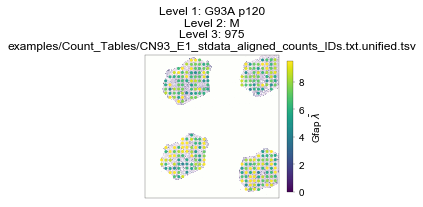

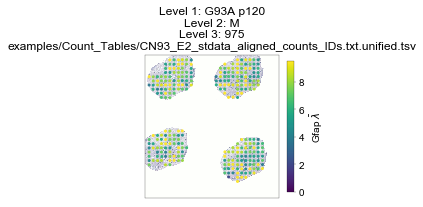

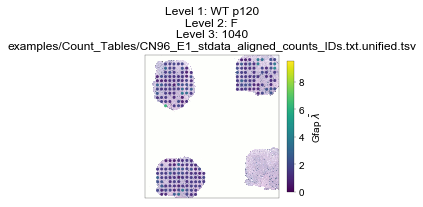

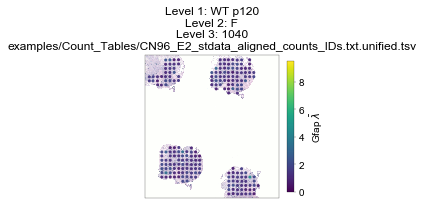

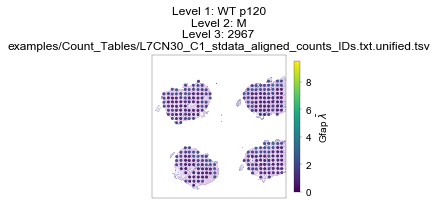

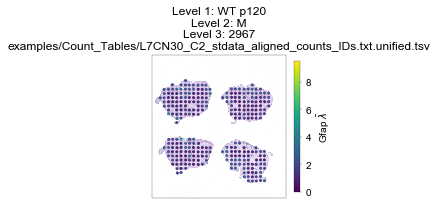

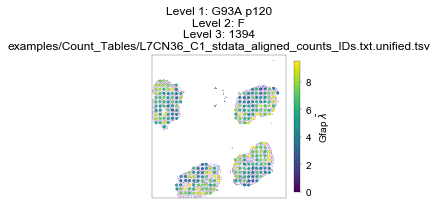

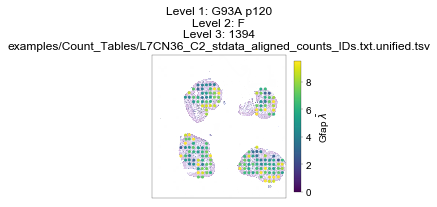

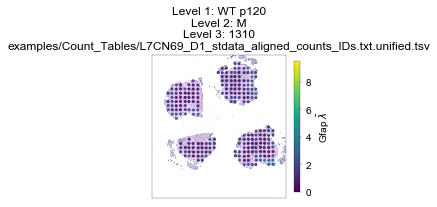

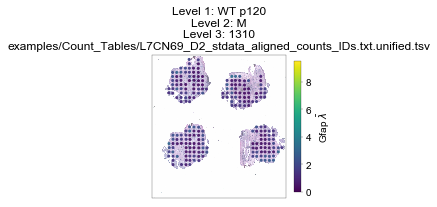

In [8]:
# get the names of the count files
count_files = numpy.array(list(lambda_posterior_means.columns.levels[0]))

# use the same color scale across the arrays
vmin,vmax = 0,numpy.percentile(lambda_posterior_means.loc[gene].values,95)

# loop over the count files
for n,count_file in enumerate(count_files):
    fig = matplotlib.pyplot.figure()
    fig.set_size_inches([3,3])
    
    ax = fig.add_subplot(1,1,1)

    # read the tissue image
    # we use the Image file column
    tissue_image = Image.open(metadata[metadata['Count file'] == count_file]
                              ['Image file'].values[0])

    xdim,ydim = tissue_image.size
    # downsample the image
    tissue_image = tissue_image.resize((numpy.round(xdim*0.05).astype(int),
                                        numpy.round(ydim*0.05).astype(int)))
    
    xdim,ydim = tissue_image.size
    pixel_dim = 194.0/(6200.0/xdim)

    coordinates = numpy.array([list(map(float,coordinate.split('_')))
                               for coordinate in list(lambda_posterior_means[count_file].columns)])
    
    x_coordinates = pixel_dim*(coordinates[:,0]-1)
    y_coordinates = pixel_dim*(coordinates[:,1]-1)

    # visualize the tissue image
    ax.imshow(tissue_image,origin='upper',interpolation='none',alpha=0.6)
    
    # visualize the ST spots on top of the tissue image
    cbmap = ax.scatter(x_coordinates,y_coordinates,
                       s=4,c=lambda_posterior_means[count_file].loc[gene],
                       cmap='viridis',vmin=0,vmax=vmax,marker='o',alpha=0.9)
    
    ax.set_aspect('equal')
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    # put some information on the array in the title
    ax.set_title('%s\n%s'%(
        '\n'.join(['Level %d: %s'%(level_idx+1,level)
                   for level_idx,level in enumerate(list(map(str,read_array_metadata(metadata,count_file,n_levels))))]),count_file))
    
    cbar = matplotlib.pyplot.colorbar(cbmap,ax=ax,shrink=0.8)
    
    cbar.set_label(r'%s $\bar{\lambda}$'%(gene))

<a id='comparing-expression-patterns'></a>
## Comparing expression patterns

### Between level 1 variables

First let us compare the expression of *Gfap* in ventral horn between WT P120 and G93A P120

In [9]:
# define the gene of interest
gene = 'Gfap'

# make sure we have analyzed it
assert gene in samples, 'Error: %s not found!'%(gene)

# define the level of interest (WT P120 and G93A P120 are level 1)
level = 'beta_level_1'
# define the variables of interest from that level
beta_variables_of_interest = ['WT p120','G93A p120']
# define the aar of interest
aar_variable_of_interest = 'Vent_Horn'

# find the mappings from names to indices (Stan has no dictionaries)
beta_variable_indices = to_stan_variables(beta_mapping[level],beta_variables_of_interest)
aar_index = to_stan_variables(aar_names,aar_variable_of_interest)

Calculate the Savage-Dickey density ratio to quantify the difference

In [10]:
print("Approximated Bayes factor (BF) is %.4f"%(
    savagedickey(samples[gene][level][:,beta_variable_indices[0],aar_index].flatten(),
                 samples[gene][level][:,beta_variable_indices[1],aar_index].flatten())))

Approximated Bayes factor (BF) is 408.7260


It looks like the gene is differentially expressed given the BF (https://en.wikipedia.org/wiki/Bayes_factor#Interpretation)

Next let us assess the expression level of the gene in the conditions

In [11]:
print('%s: %s (%s,%s): μ=%.2f, σ=%.2f (%.2f UMIs expected per %d sequenced UMIs)'%(
    gene,level,beta_variables_of_interest[0],aar_variable_of_interest,
    samples[gene][level][:,beta_variable_indices[0],aar_index].mean(),
    samples[gene][level][:,beta_variable_indices[0],aar_index].std(),
    numpy.exp(samples[gene][level][:,beta_variable_indices[0],aar_index].mean()),scaling_factor))
print('%s: %s (%s,%s): μ=%.2f, σ=%.2f (%.2f UMIs expected per %d sequenced UMIs)'%(
    gene,level,beta_variables_of_interest[1],aar_variable_of_interest,
    samples[gene][level][:,beta_variable_indices[1],aar_index].mean(),
    samples[gene][level][:,beta_variable_indices[1],aar_index].std(),
    numpy.exp(samples[gene][level][:,beta_variable_indices[1],aar_index].mean()),scaling_factor))

Gfap: beta_level_1 (WT p120,Vent_Horn): μ=-0.21, σ=0.32 (0.81 UMIs expected per 2389 sequenced UMIs)
Gfap: beta_level_1 (G93A p120,Vent_Horn): μ=1.90, σ=0.29 (6.68 UMIs expected per 2389 sequenced UMIs)


Finally, let us visualize the posterior densities

Text(0.5, 1.0, 'Vent_Horn')

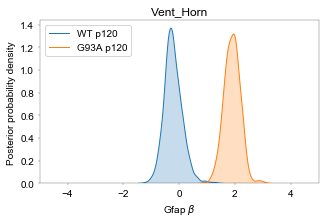

In [12]:
fig = matplotlib.pyplot.figure()
fig.set_size_inches([5,3])
    
ax = fig.add_subplot(1,1,1)

sns.distplot(samples[gene][level][:,beta_variable_indices[0],aar_index].flatten(),
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 1},
             label=beta_variables_of_interest[0])
sns.distplot(samples[gene][level][:,beta_variable_indices[1],aar_index].flatten(),
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 1},
             label=beta_variables_of_interest[1])

ax.legend()

ax.set_xlabel(r'%s $\beta$'%(gene))
ax.set_ylabel('Posterior probability density')

ax.set_xlim([-5,5])

ax.set_title('%s'%(aar_variable_of_interest))

The visual inspection of the posterior densities confirms the detected difference

### Between two AARs

First let us compare the expression of *Gfap* in G93A p120 between ventral medial white and dorsal horn

In [13]:
# define the gene of interest
gene = 'Gfap'

# make sure we have analyzed it
assert gene in samples, 'Error: %s not found!'%(gene)

# define the level of interest
level = 'beta_level_1'
# define the variable of interest from that level
beta_variable_of_interest = 'G93A p120'
# define the aars of interest
aar_variables_of_interest = ['Vent_Med_White','Dors_Horn']

# find the mappings from names to indices (Stan has no dictionaries)
beta_variable_idx = to_stan_variables(beta_mapping[level],beta_variable_of_interest)
aar_indices = to_stan_variables(aar_names,aar_variables_of_interest)

Calculate the Savage-Dickey density ratio

In [14]:
print("Approximated Bayes factor (BF) is %.4f"%(
    savagedickey(samples[gene][level][:,beta_variable_idx,aar_indices[0]].flatten(),
                 samples[gene][level][:,beta_variable_idx,aar_indices[1]].flatten())))

Approximated Bayes factor (BF) is 0.2686


It looks like the gene is not differentially expressed given the BF (https://en.wikipedia.org/wiki/Bayes_factor#Interpretation)

Next let us assess the expression level of the gene in the conditions

In [15]:
print('%s: %s (%s,%s): μ=%.2f, σ=%.2f (%.2f UMIs expected per %d sequenced UMIs)'%(
    gene,level,beta_variable_of_interest,aar_variables_of_interest[0],
    samples[gene][level][:,beta_variable_idx,aar_indices[0]].mean(),
    samples[gene][level][:,beta_variable_idx,aar_indices[0]].std(),
    numpy.exp(samples[gene][level][:,beta_variable_idx,aar_indices[0]].mean()),scaling_factor))
print('%s: %s (%s,%s): μ=%.2f, σ=%.2f (%.2f UMIs expected per %d sequenced UMIs)'%(
    gene,level,beta_variable_of_interest,aar_variables_of_interest[1],
    samples[gene][level][:,beta_variable_idx,aar_indices[1]].mean(),
    samples[gene][level][:,beta_variable_idx,aar_indices[1]].std(),
    numpy.exp(samples[gene][level][:,beta_variable_idx,aar_indices[1]].mean()),scaling_factor))

Gfap: beta_level_1 (G93A p120,Vent_Med_White): μ=1.99, σ=0.33 (7.29 UMIs expected per 2389 sequenced UMIs)
Gfap: beta_level_1 (G93A p120,Dors_Horn): μ=1.53, σ=0.31 (4.62 UMIs expected per 2389 sequenced UMIs)


Finally, let us visualize the posterior densities

Text(0.5, 1.0, 'G93A p120')

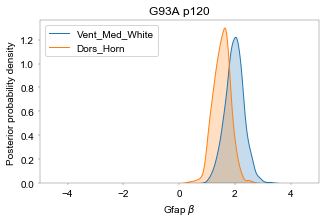

In [16]:
fig = matplotlib.pyplot.figure()
fig.set_size_inches([5,3])
    
ax = fig.add_subplot(1,1,1)

sns.distplot(samples[gene][level][:,beta_variable_idx,aar_indices[0]].flatten(),
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 1},
             label=aar_variables_of_interest[0])
sns.distplot(samples[gene][level][:,beta_variable_idx,aar_indices[1]].flatten(),
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 1},
             label=aar_variables_of_interest[1])

ax.legend()

ax.set_xlabel(r'%s $\beta$'%(gene))
ax.set_ylabel('Posterior probability density')

ax.set_xlim([-5,5])

ax.set_title('%s'%(beta_variable_of_interest))

### Between two sets of AARs

In [17]:
# define the gene of interest
gene = 'Gfap'

# make sure we have analyzed it
assert gene in samples, 'Error: %s not found!'%(gene)

# define the level of interest
level = 'beta_level_1'
# define the variable of interest from that level
beta_variable_of_interest = 'G93A p120'
# define the aars of interest
aar_variables_of_interest = [['Vent_Med_White','Vent_Horn'],['Vent_Lat_White','Med_Grey','Dors_Horn']]

# find the mappings from names to indices (Stan has no dictionaries)
beta_variable_idx = to_stan_variables(beta_mapping[level],beta_variable_of_interest)
aar_indices = to_stan_variables(aar_names,aar_variables_of_interest)

Calculate the Savage-Dickey density ratio

In [18]:
print("Approximated Bayes factor (BF) is %.4f"%(
    savagedickey(samples[gene][level][:,beta_variable_idx,aar_indices[0]].flatten(),
                 samples[gene][level][:,beta_variable_idx,aar_indices[1]].flatten())))

Approximated Bayes factor (BF) is 0.1794


It looks like the gene is not differentially expressed given the BF (https://en.wikipedia.org/wiki/Bayes_factor#Interpretation)

Next let us assess the expression level of the gene in the conditions

In [19]:
print('%s: %s (%s,%s): μ=%.2f, σ=%.2f (%.2f UMIs expected per %d sequenced UMIs)'%(
    gene,level,beta_variable_of_interest,aar_variables_of_interest[0],
    samples[gene][level][:,beta_variable_idx,aar_indices[0]].mean(),
    samples[gene][level][:,beta_variable_idx,aar_indices[0]].std(),
    numpy.exp(samples[gene][level][:,beta_variable_idx,aar_indices[0]].mean()),scaling_factor))
print('%s: %s (%s,%s): μ=%.2f, σ=%.2f (%.2f UMIs expected per %d sequenced UMIs)'%(
    gene,level,beta_variable_of_interest,aar_variables_of_interest[1],
    samples[gene][level][:,beta_variable_idx,aar_indices[1]].mean(),
    samples[gene][level][:,beta_variable_idx,aar_indices[1]].std(),
    numpy.exp(samples[gene][level][:,beta_variable_idx,aar_indices[1]].mean()),scaling_factor))

Gfap: beta_level_1 (G93A p120,['Vent_Med_White', 'Vent_Horn']): μ=1.94, σ=0.32 (6.98 UMIs expected per 2389 sequenced UMIs)
Gfap: beta_level_1 (G93A p120,['Vent_Lat_White', 'Med_Grey', 'Dors_Horn']): μ=1.72, σ=0.33 (5.58 UMIs expected per 2389 sequenced UMIs)


Finally, let us visualize the posterior densities

Text(0.5, 1.0, 'G93A p120')

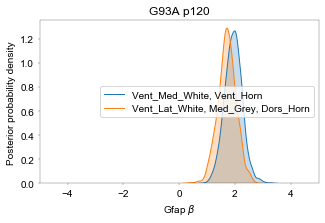

In [20]:
fig = matplotlib.pyplot.figure()
fig.set_size_inches([5,3])
    
ax = fig.add_subplot(1,1,1)

sns.distplot(samples[gene][level][:,beta_variable_idx,aar_indices[0]].flatten(),
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 1},
             label=', '.join(aar_variables_of_interest[0]))
sns.distplot(samples[gene][level][:,beta_variable_idx,aar_indices[1]].flatten(),
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 1},
             label=', '.join(aar_variables_of_interest[1]))

ax.legend()

ax.set_xlabel(r'%s $\beta$'%(gene))
ax.set_ylabel('Posterior probability density')

ax.set_xlim([-5,5])

ax.set_title('%s'%(beta_variable_of_interest))

### Between a selected AAR and all the other

In [21]:
# define the gene of interest
gene = 'Gfap'

# make sure we have analyzed it
assert gene in samples, 'Error: %s not found!'%(gene)

# define the level of interest
level = 'beta_level_1'
# define the variable of interest from that level
beta_variable_of_interest = 'G93A p120'
# define the aar of interest
aar_variables_of_interest = ['Vent_Horn']

# find the mappings from names to indices (Stan has no dictionaries)
aar_variables_of_interest = [aar_variables_of_interest,[aar for aar in aar_names if aar not in aar_variables_of_interest]]
beta_variable_idx = to_stan_variables(beta_mapping[level],beta_variable_of_interest)
aar_indices = to_stan_variables(aar_names,aar_variables_of_interest)

Calculate the Savage-Dickey density ratio

In [22]:
print("Approximated Bayes factor (BF) is %.4f"%(
    savagedickey(samples[gene][level][:,beta_variable_idx,aar_indices[0]].flatten(),
                 samples[gene][level][:,beta_variable_idx,aar_indices[1]].flatten())))

Approximated Bayes factor (BF) is 0.1649


It looks like the gene is not differentially expressed given the BF (https://en.wikipedia.org/wiki/Bayes_factor#Interpretation)

Next let us assess the expression level of the gene in the conditions

In [23]:
print('%s: %s (%s,%s): μ=%.2f, σ=%.2f (%.2f UMIs expected per %d sequenced UMIs)'%(
    gene,level,beta_variable_of_interest,aar_variables_of_interest[0],
    samples[gene][level][:,beta_variable_idx,aar_indices[0]].mean(),
    samples[gene][level][:,beta_variable_idx,aar_indices[0]].std(),
    numpy.exp(samples[gene][level][:,beta_variable_idx,aar_indices[0]].mean()),scaling_factor))
print('%s: %s (%s,%s): μ=%.2f, σ=%.2f (%.2f UMIs expected per %d sequenced UMIs)'%(
    gene,level,beta_variable_of_interest,aar_variables_of_interest[1],
    samples[gene][level][:,beta_variable_idx,aar_indices[1]].mean(),
    samples[gene][level][:,beta_variable_idx,aar_indices[1]].std(),
    numpy.exp(samples[gene][level][:,beta_variable_idx,aar_indices[1]].mean()),scaling_factor))

Gfap: beta_level_1 (G93A p120,['Vent_Horn']): μ=1.90, σ=0.29 (6.68 UMIs expected per 2389 sequenced UMIs)
Gfap: beta_level_1 (G93A p120,['Vent_Med_White', 'Vent_Lat_White', 'Med_Grey', 'Dors_Horn', 'Dors_Edge', 'Med_Lat_White', 'Vent_Edge', 'Dors_Med_White', 'Cent_Can', 'Lat_Edge']): μ=1.80, σ=0.37 (6.06 UMIs expected per 2389 sequenced UMIs)


Finally, let us visualize the posterior densities

Text(0.5, 1.0, 'G93A p120')

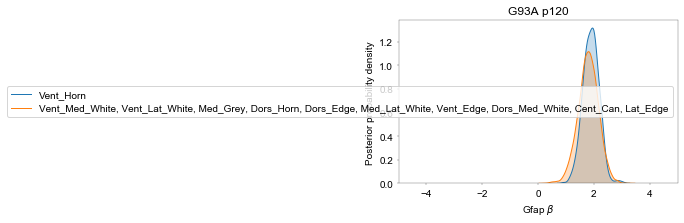

In [24]:
fig = matplotlib.pyplot.figure()
fig.set_size_inches([5,3])
    
ax = fig.add_subplot(1,1,1)

sns.distplot(samples[gene][level][:,beta_variable_idx,aar_indices[0]].flatten(),
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 1},
             label=', '.join(aar_variables_of_interest[0]))
sns.distplot(samples[gene][level][:,beta_variable_idx,aar_indices[1]].flatten(),
             hist=False,kde=True,kde_kws = {'shade': True, 'linewidth': 1},
             label=', '.join(aar_variables_of_interest[1]))

ax.legend()

ax.set_xlabel(r'%s $\beta$'%(gene))
ax.set_ylabel('Posterior probability density')

ax.set_xlim([-5,5])

ax.set_title('%s'%(beta_variable_of_interest))

<a id='registration-of-tissue-sections'></a>
## Registration of tissue sections

First, let us try to register the tissue sections using the AAR information

In [25]:
# get the names of the count files
count_files = numpy.array(list(lambda_posterior_means.columns.levels[0]))

# registration of tissue sections
registered_coordinates_dict,registered_coordinates,annotations = registration(count_files,metadata)

/Users/taijo/python37_testing/venv/lib/python3.7/site-packages/jax/lib/xla_bridge.py:109: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Let us see what `registered_coordinates_dict` (dictionary) is storing

In [26]:
# the keys of the registered_coordinates dictionary are the names of count files
print('registered_coordinates_dict has the count files as keys (only the first is listed): %s ..\n'%(list(registered_coordinates_dict.keys())))

# each element in the registered_coordinates dictionary is a dictionary with the original ST spot coordinates as keys
print("registered_coordinates_dict['%s'] has the ST spot coordinates as keys (only the first is listed): %s ..\n"%(list(registered_coordinates_dict.keys())[0],
    list(registered_coordinates_dict[list(registered_coordinates_dict.keys())[0]].keys())[0]))

# each element in the registered_coordinates dictionary is a dictionary with the original ST spot coordinates as keys
print("registered_coordinates_dict['%s']['%s'] has the common coordinate: %s\n"%(list(registered_coordinates_dict.keys())[0],
    list(registered_coordinates_dict[list(registered_coordinates_dict.keys())[0]].keys())[0],
         registered_coordinates_dict[list(registered_coordinates_dict.keys())[0]][list(registered_coordinates_dict[list(registered_coordinates_dict.keys())[0]].keys())[0]]))

registered_coordinates_dict has the count files as keys (only the first is listed): ['examples/Count_Tables/CN93_E1_stdata_aligned_counts_IDs.txt.unified.tsv', 'examples/Count_Tables/CN93_E2_stdata_aligned_counts_IDs.txt.unified.tsv', 'examples/Count_Tables/CN96_E1_stdata_aligned_counts_IDs.txt.unified.tsv', 'examples/Count_Tables/CN96_E2_stdata_aligned_counts_IDs.txt.unified.tsv', 'examples/Count_Tables/L7CN30_C1_stdata_aligned_counts_IDs.txt.unified.tsv', 'examples/Count_Tables/L7CN30_C2_stdata_aligned_counts_IDs.txt.unified.tsv', 'examples/Count_Tables/L7CN36_C1_stdata_aligned_counts_IDs.txt.unified.tsv', 'examples/Count_Tables/L7CN36_C2_stdata_aligned_counts_IDs.txt.unified.tsv', 'examples/Count_Tables/L7CN69_D1_stdata_aligned_counts_IDs.txt.unified.tsv', 'examples/Count_Tables/L7CN69_D2_stdata_aligned_counts_IDs.txt.unified.tsv'] ..

registered_coordinates_dict['examples/Count_Tables/CN93_E1_stdata_aligned_counts_IDs.txt.unified.tsv'] has the ST spot coordinates as keys (only the 

Let us visualize the registration result

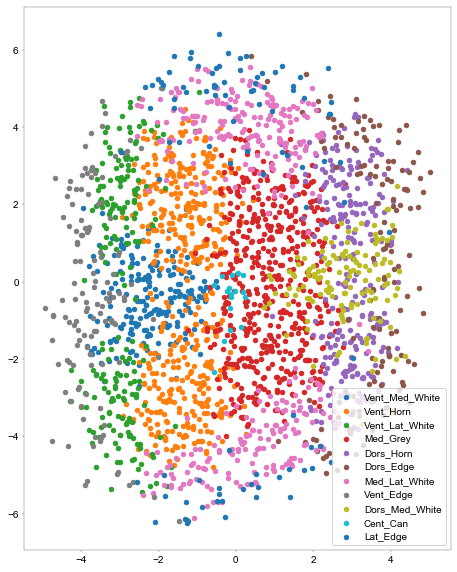

In [27]:
fig = matplotlib.pyplot.figure()
fig.set_size_inches([10,10])
    
ax = fig.add_subplot(1,1,1)

for aar in range(0,len(aar_names)):
    ax.scatter(registered_coordinates[0,annotations == aar],registered_coordinates[1,numpy.where(annotations == aar)[0]],s=20,label=aar_names[aar])
ax.legend()

ax.set_aspect('equal')

Let us visualize the expression of *Gfap*

In [28]:
# define the gene of interest
gene = 'Gfap'

assert gene in lambda_posterior_means.index, 'Error: %s not found!'%(gene)

Let us consider the following level 1 variables: WT P120 and G93A P120

In [29]:
level_1_variables_of_interest = ['WT p120','G93A p120']

Visualize the registrated tissue sections on separate axes

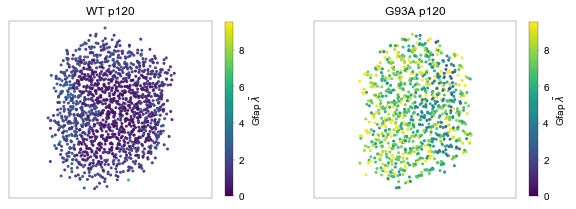

In [30]:
# get the names of the count files
count_files = numpy.array(list(lambda_posterior_means.columns.levels[0]))

# use the same color scale across the arrays
vmin,vmax = 0,numpy.percentile(lambda_posterior_means.loc[gene].values,95)

# initialize a figure
fig = matplotlib.pyplot.figure()
fig.set_size_inches([len(level_1_variables_of_interest)*5,4])

# initialize axes
ax = [fig.add_subplot(1,len(level_1_variables_of_interest),ax_idx) for ax_idx in range(1,len(level_1_variables_of_interest)+1)]

# adjust the axes
for ax_idx in range(0,len(ax)):
    ax[ax_idx].set_title(level_1_variables_of_interest[ax_idx])
    
    ax[ax_idx].set_aspect('equal')
    
    ax[ax_idx].set_xticks([])
    ax[ax_idx].set_yticks([])
    
    ax[ax_idx].set_xlim([-8,8])
    ax[ax_idx].set_ylim([-7,7])

cbmap = [None for _ in range(0,len(ax))]
    
# loop over the count files
for n,count_file in enumerate(count_files):
    
    # see if the current array has a level 1 variable of interest
    try:
        ax_idx = level_1_variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
    except ValueError:
        continue
        
    # move to the next array if the current array has not been registered 
    if count_file not in registered_coordinates_dict:
        continue
    
    # for each ST spot on the array, let us get its registered coordinate if available
    coordinates_found = numpy.zeros(len(list(lambda_posterior_means[count_file].columns))) # indicator of being registered
    coordinates = []  
    for coord_idx,coordinate in enumerate(list(lambda_posterior_means[count_file].columns)):
        if coordinate in registered_coordinates_dict[count_file]:
            coordinates_found[coord_idx] = 1
            coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
    coordinates = numpy.array(coordinates)
    x_coordinates = coordinates[:,0]
    y_coordinates = coordinates[:,1]
    
    # visualize the registered ST spots
    cbmap[ax_idx] = ax[ax_idx].scatter(x_coordinates,y_coordinates,
                               s=4,c=lambda_posterior_means[count_file].loc[gene][coordinates_found > 0],
                               cmap='viridis',vmin=0,vmax=vmax,marker='o',alpha=0.9)

# add colorbars
for ax_idx in range(0,len(ax)):
    if cbmap[ax_idx] is not None:
        cbar = matplotlib.pyplot.colorbar(cbmap[ax_idx],ax=ax[ax_idx],shrink=0.8)    
        cbar.set_label(r'%s $\bar{\lambda}$'%(gene))